100%|██████████| 4999/4999 [00:10<00:00, 485.08it/s]


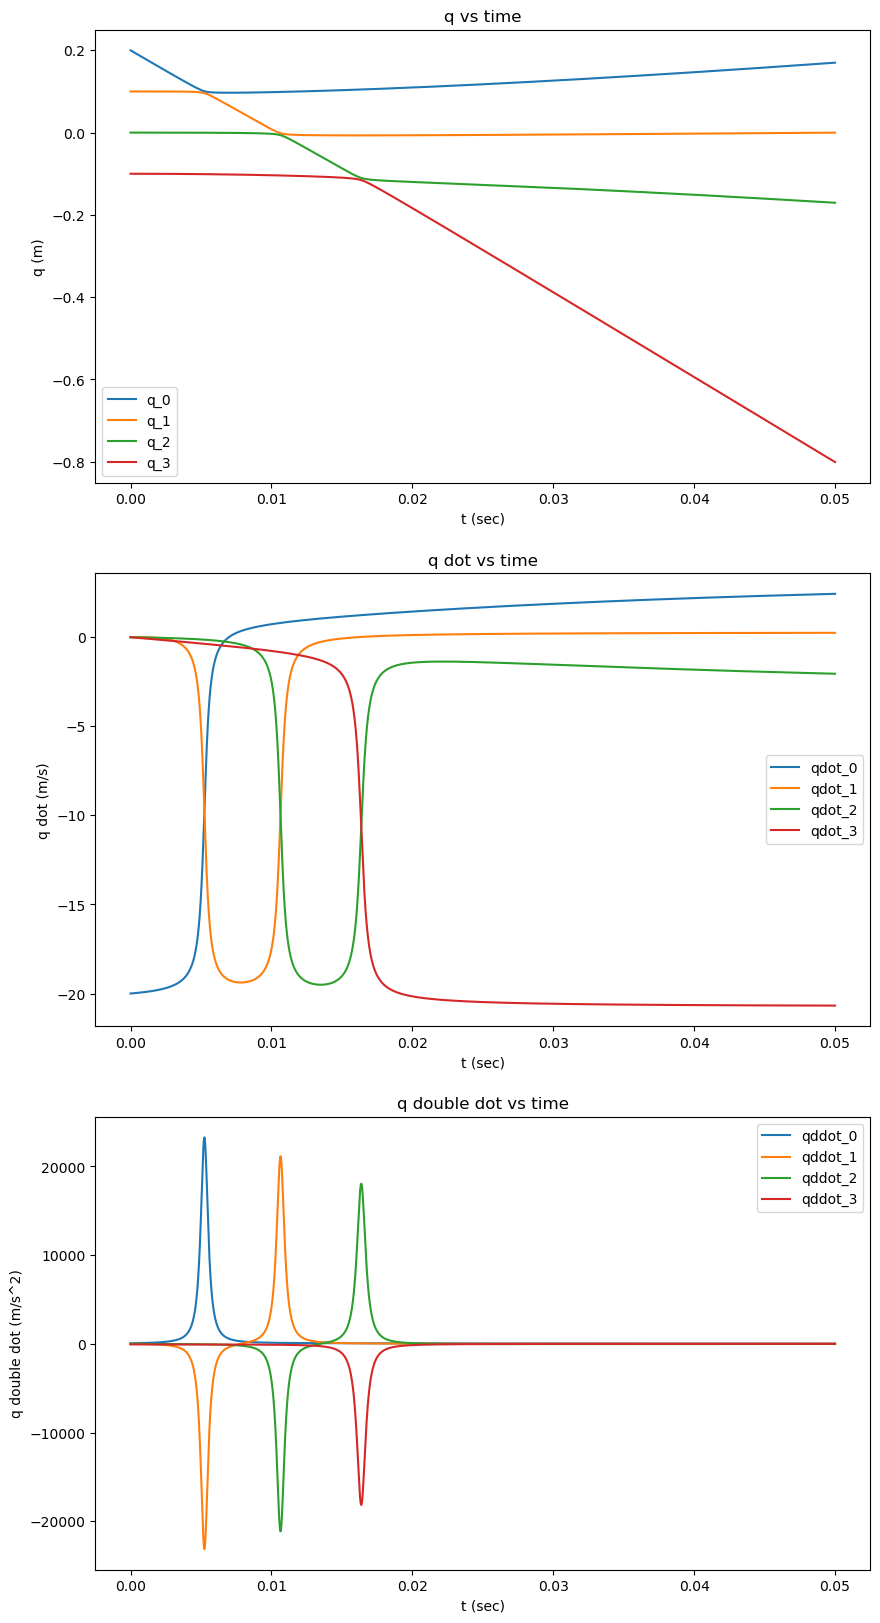

In [529]:
#toy model of autograd Lagrangian mechanics 
import torch
from torch import tensor, autograd, sum, linalg, zeros, ones, pow, tril
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time

tmax = .05
iterations = 5000
dt = tmax/iterations



d = 4

gpu = 0

#assign device
if gpu == 1:
    if torch.cuda.is_available():
        dev = torch.device('cuda')
        datatype = torch.double
    else:
        dev = torch.device('cpu')
        datatype = torch.double
        print("No MPS/CUDA device available! Data reported for CPU only!")
else:
    dev = torch.device('cpu')
    datatype = torch.double



if d == 2:
    k = tensor([1,1], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1,1], requires_grad = False, dtype=datatype, device = dev)

    p = tensor([1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([.2,.0], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([-.1,.1], requires_grad = True, dtype=datatype, device = dev)
elif d == 3:
    k = tensor([1,1,1], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1,1,1], requires_grad = False, dtype=datatype, device = dev)

    p = tensor([1,-1,1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([.2,.1,.0], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([.0,.0,0], requires_grad = True, dtype=datatype, device = dev)
elif d == 4:
    k = tensor([10,10,1,1], requires_grad = False, dtype=datatype, device = dev)
    m = tensor([1,1,1,1], requires_grad = False, dtype=datatype, device = dev)

    p = tensor([1,1,1,1], requires_grad = False, dtype=datatype, device = dev)
    
    q = tensor([.2,.1,.0,-.1], requires_grad = True, dtype=datatype, device = dev)
    qdot = tensor([-20,.0,0,0], requires_grad = True, dtype=datatype, device = dev)


def distances(q,epsillon=1e-12):
    dim = q.size()[0]
    ones = torch.ones(dim, dtype=datatype, device = dev)
    x = torch.outer(q, ones)
    y = torch.outer(ones, q)
    dist = torch.sqrt( torch.pow((x-y),2) + epsillon**2)
    return dist

def inv_distances(q,power=-1,epsillon=1e-6):
    dist = distances(q)
    invdist = torch.pow(dist+epsillon,power) # inserting epsillon term to cap invdist for very small distances
    invdist = tril(invdist,diagonal=-1)
    return invdist
    
def L(vec):
    d = int(vec.size()[0]/2)
    qtemp = vec[:d]
    qdottemp = vec[d:]
    L = (0.5*m*(qdottemp**2)).sum() - (0.5*k*(qtemp**2)).sum()  - 0.5*(p*inv_distances(qtemp).sum(axis=0) ).sum()
    return L
    

def qddot(q,qdot):
    v = torch.cat((q,qdot))

    dim = q.size()[0]
    full_hessian = autograd.functional.hessian(L,v)
    full_grad = autograd.functional.jacobian(L,v)
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break"
    grad_q = full_grad[:dim]
    hess_q = full_hessian[:dim,:dim]
    hess_qdot = full_hessian[dim:,dim:]
    hess_q_qdot = full_hessian[dim:,:dim]
    qdd = linalg.pinv(hess_qdot)@( grad_q - hess_q_qdot@qdot )
    return qdd



qdim = q.size()[0]
q_hist = zeros((qdim,iterations), device = dev)
qdot_hist = zeros((qdim,iterations), device = dev)
qddot_hist = zeros((qdim,iterations), device = dev)
dist_hist = zeros(iterations, device = dev)

q_hist[:,0] = q.data
qdot_hist[:,0] = qdot.data
qdd = qddot(q,qdot)
qdd = (0.5*qddot(q,qdot) + .5*qddot(q+dt*qdot, qdot + dt*qdd))/1
qddot_hist[:,0] = qdd


for i in tqdm.trange(1,iterations):
    #print(f"iteration {i}")
    q.data += dt*qdot.data
    qdot.data += dt*qdd
    qdd = (.5*qddot(q,qdot) + 0.5*qddot(q+dt*qdot, qdot + dt*qdd))/1
    if torch.isnan(q).max():
        print("NaN appeared in q! Breaking loop!")
        break
    q_hist[:,i] = q
    qdot_hist[:,i] = qdot
    qddot_hist[:,i] = qdd
    #dist_hist[i] = - 0.5*p*(1*( inv_distances(q.data) )).sum()

#print(q_hist.data[0,:])
q_out = q_hist.cpu().data.detach().numpy()
qdot_out = qdot_hist.cpu().data.detach().numpy()
qddot_out = qddot_hist.cpu().data.detach().numpy()
#print(q_out)

fig, axs = plt.subplots(3,1,figsize = (10,20))
for i in range(qdim):
    axs[0].plot(np.linspace(0,tmax,iterations),q_out[i,:].T,label='q_'+str(i))
axs[0].legend()
axs[0].set_xlabel('t (sec)')
axs[0].set_ylabel('q (m)')
axs[0].set_title('q vs time')

for i in range(qdim):
    axs[1].plot(np.linspace(0,tmax,iterations),qdot_out[i,:].T,label='qdot_'+str(i))
axs[1].legend()
axs[1].set_xlabel('t (sec)')
axs[1].set_ylabel('q dot (m/s)')
axs[1].set_title('q dot vs time')

for i in range(qdim):
    axs[2].plot(np.linspace(0,tmax,iterations),qddot_out[i,:].T,label='qddot_'+str(i))
axs[2].legend()
axs[2].set_xlabel('t (sec)')
axs[2].set_ylabel('q double dot (m/s^2)')
axs[2].set_title('q double dot vs time')

plt.show()


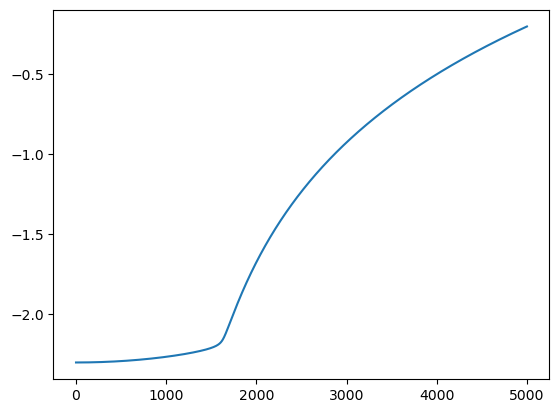

In [517]:
plt.plot(np.log(np.abs(q_out[3,:])))

In [387]:
qdd

tensor([nan, nan], dtype=torch.float64, grad_fn=<DivBackward0>)

In [167]:
def d_sum(q):
    return distances(q).sum()

In [103]:
distances(q + tensor([0,1]))

tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [93]:
q - tensor([0,.5])

tensor([ 1.0000, -0.5000], dtype=torch.float64, grad_fn=<SubBackward0>)

In [115]:
pd = torch.nn.PairwiseDistance(p=2)

In [123]:
pd(torch.cat((q,qdot)),torch.cat((q,q)))

tensor(1.0050, dtype=torch.float64, grad_fn=<NormBackward1>)

In [57]:
d_test(q)

tensor([[ 0.0000, -0.5000],
        [ 0.5000,  0.0000]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [139]:
torch.outer(q,q).shape

torch.Size([2, 2])

In [145]:
q

tensor([1., 0.], dtype=torch.float64, requires_grad=True)

In [163]:
inv_distances(torch.tensor([1,.1,3]))

tensor([[2.0000e-06, 9.0000e-01, 2.0000e+00],
        [9.0000e-01, 2.0000e-06, 2.9000e+00],
        [2.0000e+00, 2.9000e+00, 2.0000e-06]], dtype=torch.float64)

In [481]:
inv_distances(tensor(q_out[:,1000]))

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 9.2556,  0.0000,  0.0000],
        [ 4.9723, 10.7444,  0.0000]], dtype=torch.float64)

In [487]:
autograd.functional.hessian(L,tensor([1.,2,3,4,5,6]))

tensor([[-2.1250,  1.0000,  0.1250,  0.0000,  0.0000,  0.0000],
        [ 1.0000, -1.0000, -1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1250, -1.0000, -0.1250,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000]])

In [337]:
test = tensor([[1,2,3],[4,5,6],[7,8,9]])

In [27]:
- 0.5*p*(0.5*( distances(q) )).sum()

tensor([-0.5000], dtype=torch.float64, grad_fn=<MulBackward0>)

In [235]:
q = tensor([2,1.], requires_grad = True, dtype=datatype, device = dev)
qdot = tensor([1,1], requires_grad = True, dtype=datatype, device = dev)

vec = torch.cat((q,qdot))

In [137]:
qddot(qdot,qdot)

tensor([[nan, nan, 0., 0.]], dtype=torch.float64)
NaN appeared in Hessian! Breaking loop!


'break'

In [173]:
d_test(q)

tensor(2.0020, dtype=torch.float64, grad_fn=<SumBackward0>)

In [439]:
autograd.functional.hessian(L,vec)

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

In [147]:
linalg.pinv(autograd.functional.hessian(d_test,vec))

tensor([[ 68343.8770, -22781.2928, -22781.2928, -22781.2928],
        [-22781.2918,   7593.7642,   7593.7640,   7593.7640],
        [-22781.2918,   7593.7640,   7593.7642,   7593.7640],
        [-22781.2918,   7593.7640,   7593.7640,   7593.7642]],
       dtype=torch.float64)

In [203]:
q

tensor([ 0.2653, -0.0946], dtype=torch.float64, requires_grad=True)

In [217]:
pd = torch.nn.PairwiseDistance(2)

In [219]:
pd

PairwiseDistance()

In [441]:
inv_distances(q)

tensor([[0.0000, 0.0000, 0.0000],
        [0.8659, 0.0000, 0.0000],
        [2.6754, 1.2804, 0.0000]], dtype=torch.float64,
       grad_fn=<TrilBackward0>)

In [489]:
(p*inv_distances(q).sum(axis=0)).sum()

tensor(1.0735, dtype=torch.float64, grad_fn=<SumBackward0>)

In [393]:
0.5*(p*1*( inv_distances(q*100).sum(axis=1) )).sum()

tensor(250000.0500, dtype=torch.float64)

In [495]:
inv_distances(q_hist[:,0])

tensor([[0.0000, 0.0000, 0.0000],
        [9.9999, 0.0000, 0.0000],
        [5.0000, 9.9999, 0.0000]], dtype=torch.float64,
       grad_fn=<TrilBackward0>)

In [399]:
p

tensor([ 1., -1.,  1.], dtype=torch.float64)

In [425]:
a = tensor([[0,1,0],[1,0,0],[0,0,1]])

In [429]:
b = tensor([1,0,0])

In [433]:
a@b

tensor([0, 1, 0])